# Health Insurance Cross-Sell Project

## 0.1 Import Libraries

In [1]:
import pandas            as pd
import numpy             as np
import seaborn           as sns
import matplotlib.pyplot as plt
import scikitplot        as skplt

import math 
import inflection
import datetime
import pickle
import warnings
import random
import json
import requests

from sklearn.neighbors       import KNeighborsClassifier
from sklearn.preprocessing   import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.ensemble        import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import train_test_split 
from sklearn                 import metrics      as mt
from sklearn                 import linear_model as lm

from IPython.display       import Image
from tabulate              import tabulate
from scipy                 import stats as ss

warnings.filterwarnings( 'ignore' )

## 0.2 Support Functions

In [108]:
# data cleaning functions
def rename_columns( df ):
    title = lambda x: inflection.titleize( x )
    snakecase = lambda x: inflection.underscore( x )
    spaces = lambda x: x.replace(" ", "")

    cols_old = list( df.columns )
    cols_old = list( map( title, cols_old ) )
    cols_old = list( map( spaces, cols_old ) )
    cols_new = list( map( snakecase, cols_old ) )
    
    df.columns = cols_new

    return df

def change_data_types( df ):
    df['region_code']          = df['region_code'].astype( int )
    df['policy_sales_channel'] = df['policy_sales_channel'].astype( int )
    
    return df

# feature engineering functions
def create_features( df ):
    # male column
    df['male'] = df['gender'].apply( lambda x : 1 if x == 'Male' else 0 )

    # old_age column
    median_age = df['age'].median()
    df['old_age'] = df['age'].apply( lambda x : 1 if x > median_age else 0 )    

    # old_annual_premium column
    median_premium = df['annual_premium'].median()
    df['old_annual_premium'] = df['annual_premium'].apply( lambda x : 1 if x > median_premium else 0 )

    # old_vintage column
    median_premium = df['vintage'].median()
    df['old_vintage'] = df['vintage'].apply( lambda x : 1 if x > median_premium else 0 )
    
    return df

# data preparation functions
def rescaling_features( df, train=False ):
    # annual_premium
    rs_annual_premium = RobustScaler()
    df['annual_premium'] = rs_annual_premium.fit_transform( df[['annual_premium']].values )
        
    # age column
    mms_age = MinMaxScaler()
    df['age'] = mms_age.fit_transform( df[['age']].values )
        
    # vintage column
    mms_vintage = MinMaxScaler()
    df['vintage'] = mms_vintage.fit_transform( df[['vintage']].values )
        
    # region_code
    ss_region_code = StandardScaler()
    df['region_code'] = ss_region_code.fit_transform( df[['region_code']].values )
        
    # policy_sales_channel
    ss_policy_sales_channel = StandardScaler()
    df['policy_sales_channel'] = ss_policy_sales_channel.fit_transform( df[['policy_sales_channel']].values )
        
    if train:
        pickle.dump( rs_annual_premium,       open( '../parameters/annual_premium_scaler.pkl', 'wb' ) )
        pickle.dump( mms_age,                 open( '../parameters/age_scaler.pkl', 'wb' ) )
        pickle.dump( mms_vintage,             open( '../parameters/vintage_scaler.pkl', 'wb' ) )
        pickle.dump( ss_region_code,          open( '../parameters/region_code_scaler.pkl', 'wb' ) )
        pickle.dump( ss_policy_sales_channel, open( '../parameters/policy_sales_channel_scaler.pkl', 'wb' ) )
    
    return df
    
def encoding_features( df ):
    # Enconding     
    bool_dict = { 'Yes' : 1, 'No' : 0 }
    df['vehicle_damage'] = df['vehicle_damage'].map( bool_dict )
   
    # Apply Ordinal Encoding - vehicle_age
    _dict = { '< 1 Year' : 1, '1-2 Year' : 2, '> 2 Years' : 3 }
    df['vehicle_age'] = df['vehicle_age'].map( _dict )

    return df

def drop_cols( df ):
    cols_drop = ['gender', 'old_age', 'old_annual_premium', 'old_vintage']
    df = df.drop( cols_drop, axis=1 )

    return df

def select_features( df ):
    final_features = ['vintage', 'annual_premium', 'age', 'region_code', 'vehicle_damage', 'policy_sales_channel', 'previously_insured']
    final_features.extend( ['id', 'response'] )

    return df[final_features]

def create_dataset( df, train=False ):
    # data clening
    df = rename_columns( df )
    df = change_data_types( df )

    # feature enginering
    df = create_features( df )

    # data preparation
    df = rescaling_features( df, train )
    df = encoding_features( df )
    df = drop_cols( df )

    # feature selection
    df = select_features( df )

    y = df['response']
    x = df.drop( columns=['id', 'response'], axis=1 )

    return df, x, y


# returns cramer´s v
def cramer_v( x, y ):
    # create confunsion matrix 
    cm = pd.crosstab( x, y ).values

    # sum of confusion matrix
    n = cm.sum()

    # confusion matrix - rows and cols
    r, k = cm.shape

    # calculate chi2
    chi2 = ss.chi2_contingency( cm )[0]    

    # calculate adjusted chi2, k, r
    chi2_adj = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    k_adj = k - (k-1)**2/(n-1)
    r_adj = r - (r-1)**2/(n-1)

    # calculate and return cramer´s v
    return np.sqrt( ( chi2_adj/n ) / ( min( k_adj-1, r_adj-1) ) )    

# sort by propensity score
def get_propensity_score( x_test, y_test, y_hat ):
    df             = x_test.copy()
    df['response'] = y_test
    df['score']    = y_hat[:,1].tolist()

    df = df.sort_values( 'score', ascending=False ).reset_index( drop=True)    

    return df

def get_precision_recall( df, model_name ):
    df['ranking']        = df.index+1
    df['precision_at_k'] = round( df['response'].cumsum() / df['ranking'], 4 )
    df['recall_at_k']    = round( df['response'].cumsum() / df['response'].sum(), 4 )

    list_precision = []
    list_recall    = []
    max_rank       = df['ranking'].max()

    for i in range(1, 11):
        pos_rank = int( max_rank * i / 10 )
        list_precision.append( df.loc[pos_rank-1, 'precision_at_k'] )
        list_recall.append( df.loc[pos_rank-1, 'recall_at_k'] )

    df_precision = pd.DataFrame( list_precision ).rename( columns = {0 : model_name } )
    df_recall    = pd.DataFrame( list_recall ).rename( columns = {0 : model_name } )
    
    return df_precision, df_recall

def cross_validation( x_train, x_validation, kfold, model_name, model, verbose=False ):
    rows       = int( x_validation.shape[0] / kfold )
    training   = x_train.copy()

    precision_list = []
    recall_list    = []

    for k in range( 1, kfold+1 ) :
        if verbose:
            print(f'\nValidation Block: { k }' )
        
        # filtering dataset
        validation = x_validation.sample( rows )

        # training dataset
        xtraining = training.drop( ['id', 'response'], axis=1 )
        ytraining = training['response']

        # validation
        xvalidation = validation.drop( ['id', 'response'], axis=1 )
        yvalidation = validation['response']
                                                                          
        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        y_hat = m.predict_proba( xvalidation )

        # create dataframe response and propensity score ( for response==1 )
        df_score = get_propensity_score( validation, y_validation, y_hat )

        # update training e x_validation
        training = pd.concat( [training, validation] )
        ids_ = validation['id'].values
        x_validation = x_validation[ ~x_validation['id'].isin( ids_ )]
        
    # performance
    df_precision, df_recall_= get_precision_recall( df_score, model_name )        

    return df_precision, df_recall, m


def get_model_prediction( test_file, local=True ):
    x_test = pd.read_csv( test_file,  low_memory= False )

    #y_test = x_test['response'].values
    #x_test = x_test.drop( columns=['response'], axis=1 )

    # convert dataframe to json
    json_data = json.dumps( x_test.to_dict( orient='records' ) )

    # API CALL

    # Render´s Server request
    url = 'https://rossmann-app-9l04.onrender.com/hics/predict'

    # local request
    if local:
        url = 'http://0.0.0.0:5000/hics/predict'

    
    header = { 'Content-type' : 'application/json' }
    response = requests.post( url, data=json_data, headers=header )

    check_status = response.status_code

    if check_status == 200:
        # return dataframe with predictions
        df = pd.DataFrame( response.json(), columns=response.json()[0].keys() )
        df = df[['id', 'score']]
        df = df.sort_values( 'score', ascending=False ).reset_index( drop=True)  

        return df
    
    else:
        return pd.DataFrame()



## 0.3 Load Data

In [3]:
# reading data
df_train_raw = pd.read_csv ( '../data/train.csv', low_memory= False )
df_train_raw.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


## 0.4 Create train, test and validation dataframes

In [4]:
# split train in train and test datasets (80/20)
X_train, X_test, y_train, y_test = train_test_split( df_train_raw, 
                                                     df_train_raw['Response'], 
                                                     test_size=0.2, 
                                                     random_state=1 )

In [5]:
# split test in test and validation datasets (50/50)
X_test, X_validation, y_test, y_validation = train_test_split( X_test, 
                                                               y_test, 
                                                               test_size=0.5, 
                                                               random_state=1 )

In [6]:
len_full       = df_train_raw.shape[0]
len_train      = X_train.shape[0]
len_validation = X_validation.shape[0]
len_test       = X_test.shape[0]

list_datasets = ['Full', 'Train', 'Validation', 'Test']
list_rows     = [len_full, len_train, len_validation, len_test]
list_rows_p   = [100, 
                 round( len_train / len_full * 100, 2 ),
                 round( len_validation / len_full * 100, 2 ),
                 round( len_test / len_full * 100, 2 ) ]

list_rows_negative = [df_train_raw['Response'].value_counts()[0], 
                      X_train['Response'].value_counts()[0], 
                      X_validation['Response'].value_counts()[0], 
                      X_test['Response'].value_counts()[0] ]

list_rows_negative_p = [df_train_raw['Response'].value_counts( normalize=True )[0], 
                        X_train['Response'].value_counts( normalize=True )[0], 
                        X_validation['Response'].value_counts( normalize=True  )[0], 
                        X_test['Response'].value_counts( normalize=True  )[0] ]

list_rows_positive = [df_train_raw['Response'].value_counts()[1], 
                      X_train['Response'].value_counts()[1], 
                      X_validation['Response'].value_counts()[1], 
                      X_test['Response'].value_counts()[1] ]

list_rows_positive_p = [df_train_raw['Response'].value_counts( normalize=True )[1], 
                        X_train['Response'].value_counts( normalize=True )[1], 
                        X_validation['Response'].value_counts( normalize=True  )[1], 
                        X_test['Response'].value_counts( normalize=True  )[1] ]


datasets = pd.DataFrame ( { 'Datasets'              : list_datasets,
                            'Rows'                  : list_rows,
                            'Rows %'                : list_rows_p,
                            'Rows Negative Class'   : list_rows_negative,
                            'Rows Negative Class %' : list_rows_negative_p,
                            'Rows Positive Class'   : list_rows_positive,
                            'Rows Positive Class %' : list_rows_positive_p                           
           } )

datasets


,Datasets,Rows,Rows %,Rows Negative Class,Rows Negative Class %,Rows Positive Class,Rows Positive Class %
0,Full,381109,100.0,334399,0.877437,46710,0.122563
1,Train,304887,80.0,267347,0.876872,37540,0.123128
2,Validation,38111,10.0,33465,0.878093,4646,0.121907
3,Test,38111,10.0,33587,0.881294,4524,0.118706


# 1.0 Data Cleaning

In [7]:
df1 = X_train.copy()

## 1.1 Rename Columns

In [8]:
df1.columns

Index(['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response'],
      dtype='object')

In [9]:
df1 = rename_columns( df1 )
df1.columns

Index(['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage', 'response'],
      dtype='object')

## 1.2 List Data Types

In [10]:
# list data types
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## 1.3 Check NA

In [11]:
# number of rows with NA values by column
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## 1.4 Fillout NA

In [12]:
#df1 = fillout_na( df1 )
#df1.isna().sum()

## 1.5 Change Data Types

In [13]:
df1 = change_data_types( df1 )
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code               int64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel      int64
vintage                   int64
response                  int64
dtype: object

# 2.0 Feature Engineering

In [14]:
df2 = df1.copy()

## 2.1 Descriptive Statistical

In [15]:
# identify and separate numerical and categorical attrributes
df_num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
df_cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### 2.1.1 Numerical Attributes

In [16]:
# Central Tendency - mean, median
df_mean = pd.DataFrame( df_num_attributes.apply( np.mean ) ).T
df_median = pd.DataFrame( df_num_attributes.apply( np.median ) ).T

# Dispersion - min, max, range, std, skew, kurtosis
df_min =      pd.DataFrame( df_num_attributes.apply( np.min ) ).T
df_max =      pd.DataFrame( df_num_attributes.apply( np.max ) ).T
df_range =    pd.DataFrame( df_num_attributes.apply( lambda x: x.max() - x.min() ) ).T
df_std =      pd.DataFrame( df_num_attributes.apply( np.std ) ).T
df_skew =     pd.DataFrame( df_num_attributes.apply( lambda x: x.skew() ) ).T
df_kurtosis = pd.DataFrame( df_num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate dataframes
df_numerical = pd.concat( [df_min, df_max, df_range, df_mean, df_median, df_std, df_skew, df_kurtosis] ).T.reset_index()
df_numerical.columns =  ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis'] 
df_numerical

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190538.356378,190584.0,109969.901374,0.000288,-1.198795
1,age,20.0,85.0,65.0,38.841299,36.0,15.516038,0.670792,-0.569152
2,driving_license,0.0,1.0,1.0,0.997891,1.0,0.045875,-21.706452,469.173124
3,region_code,0.0,52.0,52.0,26.390446,28.0,13.231075,-0.115820,-0.867387
4,previously_insured,0.0,1.0,1.0,0.457770,0.0,0.498213,0.169528,-1.971273
5,annual_premium,2630.0,540165.0,537535.0,30583.350595,31681.0,17266.919106,1.881654,36.202171
6,policy_sales_channel,1.0,163.0,162.0,112.006691,133.0,54.223491,-0.898867,-0.973401
7,vintage,10.0,299.0,289.0,154.331142,154.0,83.647192,0.003358,-1.200986
8,response,0.0,1.0,1.0,0.123128,0.0,0.328584,2.293932,3.262147


### 2.1.2 Categorical Attributes

In [17]:
df_cat_attributes.apply( lambda x: x.unique().shape[0] )

gender            2
vehicle_age       3
vehicle_damage    2
dtype: int64

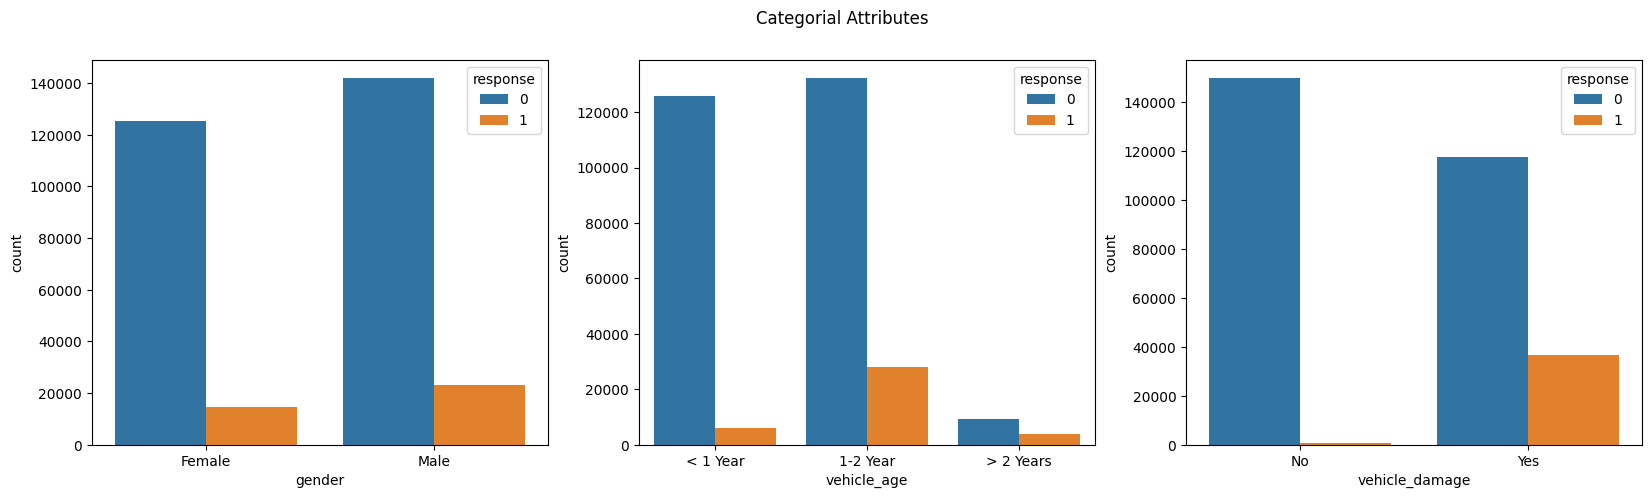

In [18]:

df1_aux = df1.copy()

fig, axes = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle('Categorial Attributes')

sns.countplot( ax=axes[0], data=df1, x='gender', hue='response' );
sns.countplot( ax=axes[1], data=df1, x='vehicle_age', hue='response' );
sns.countplot( ax=axes[2], data=df1, x='vehicle_damage', hue='response' );



## 2.1 Hypothesis Mind Map

In [19]:
#Image( '../img/mapa_de_hipoteses.png')

## 2.2 List of Hypotheses

**1.** Clientes do sexo masculino possuem MAIOR interesse em adquirir o seguro automóvel

**2.** Clientes mais velhos possuem MAIOR interesse em adquirir o seguro automóvel

**3.** Clientes que já possuem seguro possuem MENOR interesse em adquirir o seguro automóvel

**4.** Clientes que pagam um prêmio anual maior possuem MAIOR interesse em adquirir o seguro automóvel

**5.** Clientes associados há mais tempo possuem MAIOR interesse em adquirir o seguro automóvel

## 2.3 Create Features

In [20]:
df2 = create_features( df2 )

In [21]:
# generate male column
df2[['id', 'gender', 'male']].sample(10)

,id,gender,male
98878,98879,Male,1
371508,371509,Female,0
249015,249016,Female,0
322495,322496,Female,0
121587,121588,Female,0
30815,30816,Male,1
372333,372334,Female,0
340372,340373,Female,0
227416,227417,Male,1
27725,27726,Female,0


In [22]:
# generate old_age column
df2[['id', 'age', 'old_age']].sample(10)

,id,age,old_age
278587,278588,22,0
9239,9240,57,1
193853,193854,32,0
345888,345889,56,1
8441,8442,25,0
337140,337141,58,1
366362,366363,22,0
104006,104007,27,0
156168,156169,41,1
176825,176826,77,1


In [23]:
# generate old_annual_premium column
df2[['id', 'annual_premium', 'old_annual_premium']].sample(10)

,id,annual_premium,old_annual_premium
190437,190438,23157.0,0
364659,364660,58820.0,1
275908,275909,25042.0,0
21816,21817,39282.0,1
184522,184523,31958.0,1
48035,48036,42916.0,1
250741,250742,18172.0,0
330990,330991,14679.0,0
163206,163207,50656.0,1
79962,79963,31442.0,0


In [24]:
# generate old_vintage column
df2[['id', 'vintage', 'old_vintage']].sample(10)

,id,vintage,old_vintage
289652,289653,224,1
349439,349440,229,1
54312,54313,130,0
283649,283650,212,1
187098,187099,231,1
366676,366677,28,0
96441,96442,217,1
228043,228044,259,1
169801,169802,43,0
16988,16989,136,0


# 3.0 Exploratory Data Analysis

In [25]:
df3 = df2.copy()

## 3.1 Univariate Analysis

### 3.1.1 Response Variable

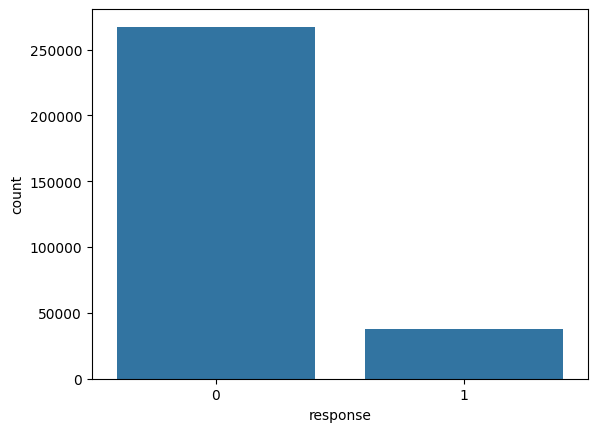

In [26]:
# checking distribuition 
sns.countplot( data=df3, x='response');

### 3.1.2 Numerical Variables

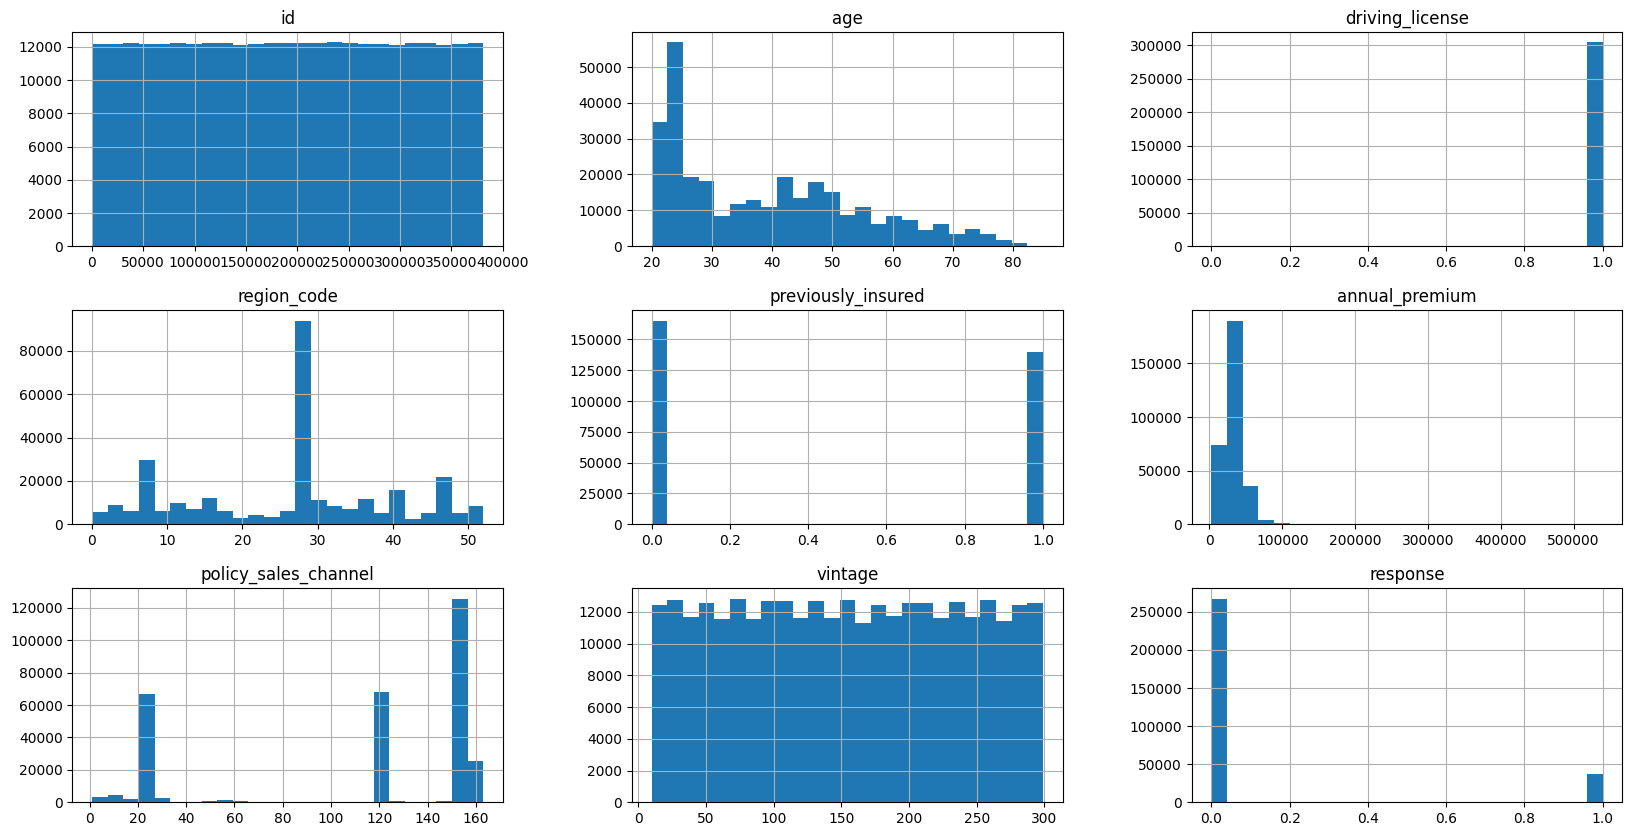

In [27]:
# cheking distribuition
df_num_attributes.hist( bins=25, figsize=(20, 10) );

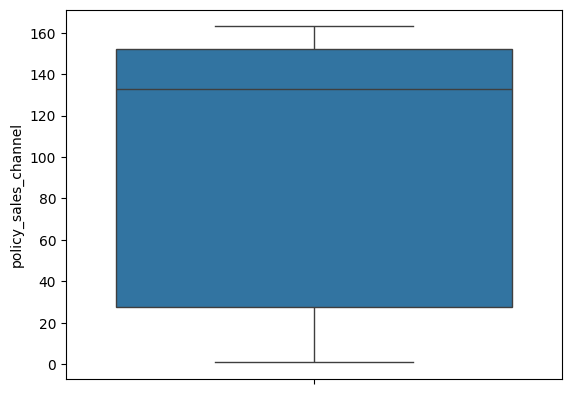

In [28]:
sns.boxplot( df3['policy_sales_channel'] );

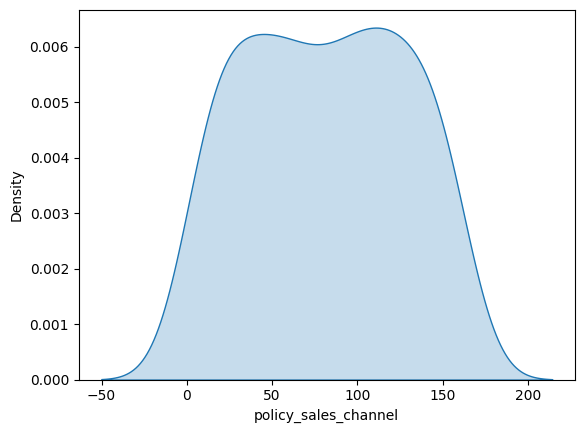

In [29]:
aux = df3[['policy_sales_channel', 'id']].groupby('policy_sales_channel').count().reset_index()
sns.kdeplot(  data=aux, x='policy_sales_channel',   fill=True );

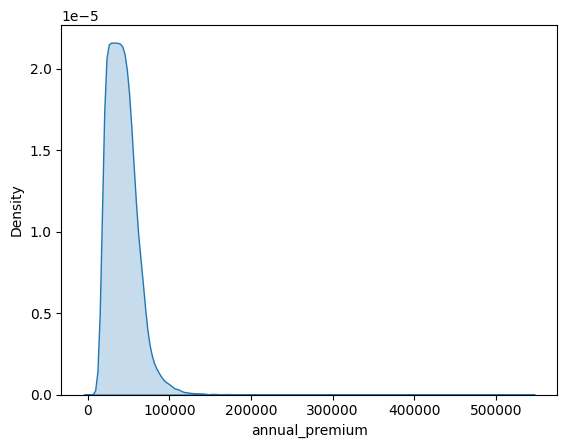

In [30]:
aux = df3[['annual_premium', 'id']].groupby('annual_premium').count().reset_index()
sns.kdeplot(  data=aux, x='annual_premium',   fill=True );

### 3.1.3 Categorical Variables

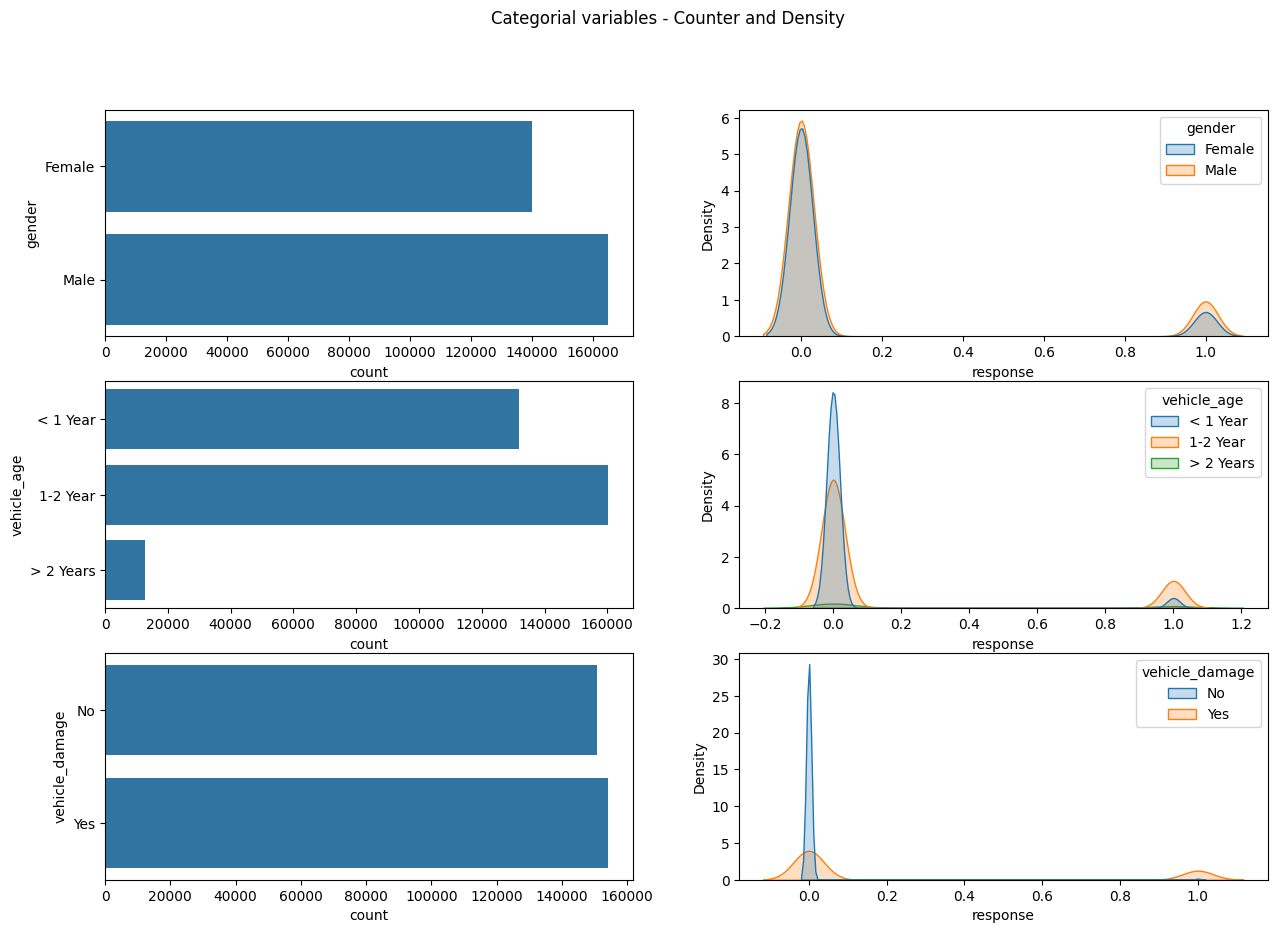

In [31]:
fig, axes = plt.subplots(3, 2, figsize=(15, 10))
fig.suptitle('Categorial variables - Counter and Density')

# gender
sns.countplot( ax=axes[0,0], data=df3['gender'] );
sns.kdeplot  ( ax=axes[0,1], data=df3[['gender', 'response']], x='response',  hue='gender', fill=True );

# vehicle_age
sns.countplot( ax=axes[1,0], data=df3['vehicle_age'] );
sns.kdeplot  ( ax=axes[1,1], data=df3[['vehicle_age', 'response']], x='response',  hue='vehicle_age', fill=True );

# vehicle_damage
sns.countplot( ax=axes[2,0], data=df3['vehicle_damage'] );
sns.kdeplot  ( ax=axes[2,1], data=df3[['vehicle_damage', 'response']], x='response',  hue='vehicle_damage', fill=True );


## 3.2 Bivariate Analysis

###  H1 - Clientes do sexo masculino possuem MAIOR interesse em adquirir o seguro automóvel

***VERDADEIRA*** Variável **male** possui relação FRACA com a variável resposta

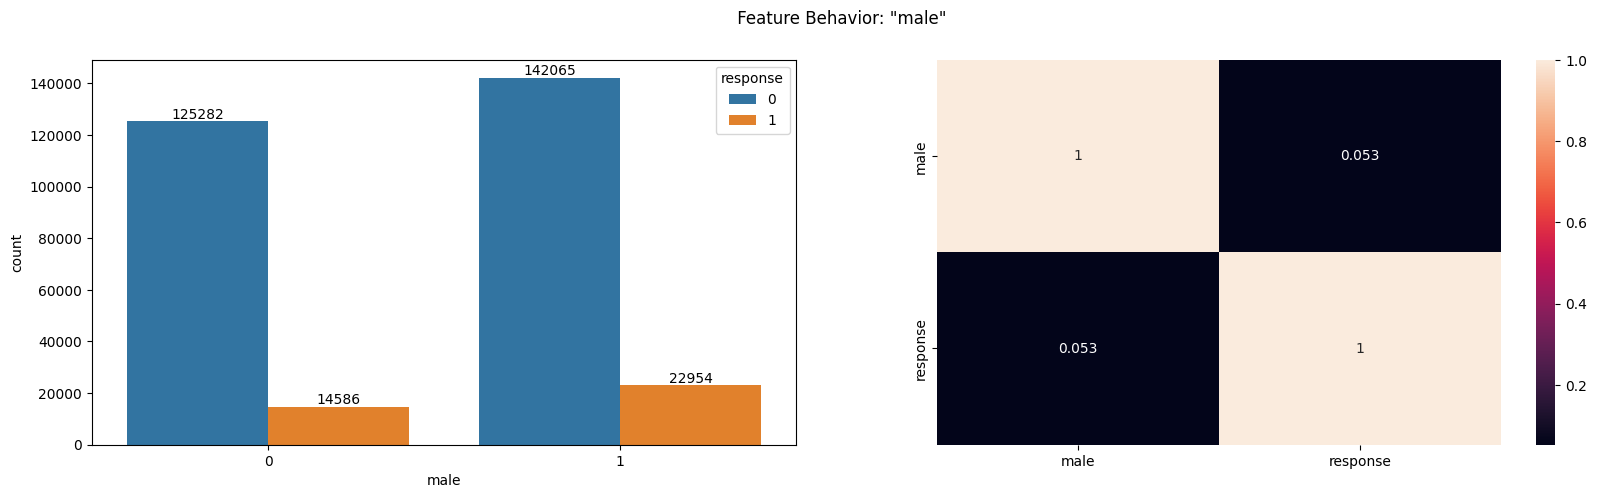

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5) )
fig.suptitle(' Feature Behavior: "male" ')

# sales x assortments - total
aux1 = df3[['male', 'response', 'id']].groupby( ['male', 'response'] ).count().reset_index().rename( columns= { 'id' : 'count' } )
ax=sns.barplot( x='male', y='count', hue='response', data=aux1, ax=axes[0]);
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f')

# sales x competition_distance corr method
aux3 = df3[['male', 'response']]
sns.heatmap( aux3.corr( method='pearson' ), annot=True, ax=axes[1] );

### H2 - Clientes mais velhos possuem MAIOR interesse em adquirir o seguro automóvel

***VERDADEIRA*** Variável **age** possui relação FRACA com a variável resposta

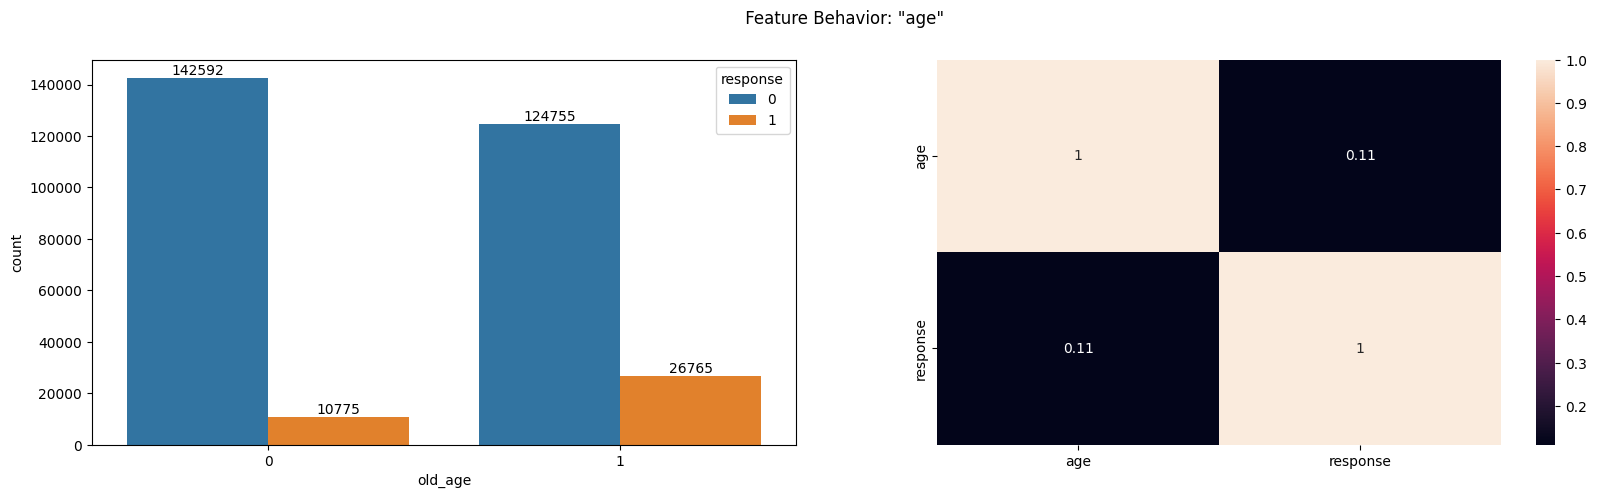

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5) )
fig.suptitle(' Feature Behavior: "age"')

# sales x assortments - total
aux1 = df3[['old_age', 'response', 'id']].groupby( ['old_age', 'response'] ).count().reset_index().rename( columns= { 'id' : 'count' } )
ax=sns.barplot( x='old_age', y='count', hue='response', data=aux1, ax=axes[0] );
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f')

# sales x competition_distance corr method
aux3 = df3[['age', 'response']]
sns.heatmap( aux3.corr( method='pearson' ), annot=True, ax=axes[1] );


### H3 - Clientes que já possuem seguro possuem MENOR interesse em adquirir o seguro automóvel

**VERDADEIRA**  Variável **previously_insured** apresenta uma correlação MÉDIA com a variável resposta

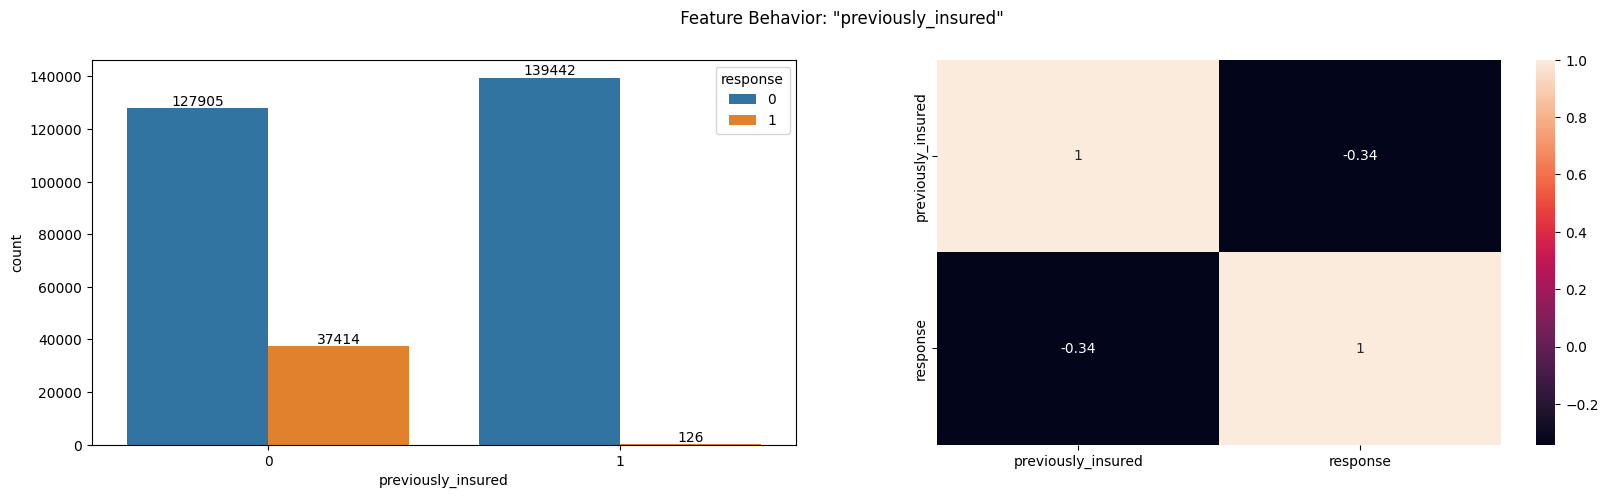

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5) )
fig.suptitle(' Feature Behavior: "previously_insured" ')

# sales x assortments - total
aux1 = ( df3[['previously_insured', 'response', 'id']]
            .groupby( ['previously_insured', 'response'] )
            .count()
            .reset_index()
            .rename( columns= { 'id' : 'count' } ) )

ax=sns.barplot( x='previously_insured', y='count', hue='response', data=aux1, ax=axes[0] );
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f')

# sales x competition_distance corr method
aux3 = df3[['previously_insured', 'response']]
sns.heatmap( aux3.corr( method='pearson' ), annot=True, ax=axes[1] );


### H4 - Clientes que pagam um prêmio anual maior possuem MAIOR interesse em adquirir o seguro automóvel

**VERDADEIRA** Variável **ANNUAL_PREMIUM** possui BAIXA correlação com a variável resposta

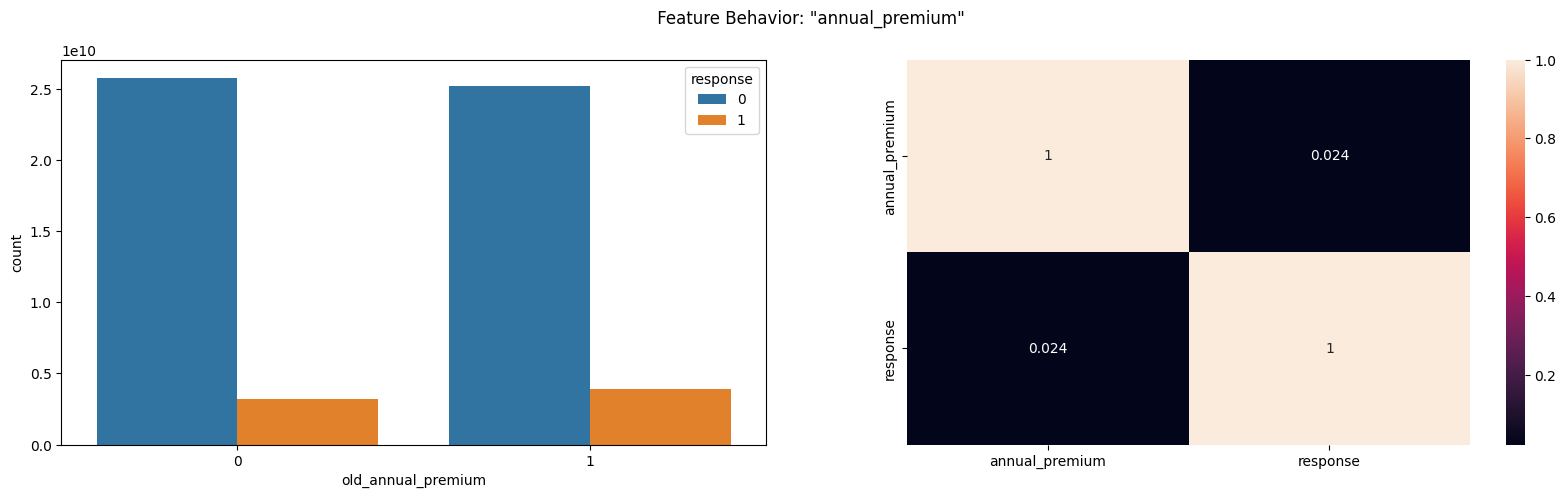

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5) )
fig.suptitle(' Feature Behavior: "annual_premium" ')

# sales x assortments - total
aux1 = df3[['old_annual_premium', 'response', 'id']].groupby( ['old_annual_premium', 'response'] ).sum().reset_index().rename( columns= { 'id' : 'count' } )
sns.barplot( x='old_annual_premium', y='count', hue='response', data=aux1, ax=axes[0]);

# sales x competition_distance corr method
aux3 = df3[['annual_premium', 'response']]
sns.heatmap( aux3.corr( method='pearson' ), annot=True, ax=axes[1] );


### H5 - Clientes associados há mais tempo possuem MAIOR interesse em adquirir o seguro automóvel





**FALSA** Clientes associados há mais tempo possuem MENOR interesse em adquirir o seguro automóvel

variável **VINTAGE** possui uma correlação FRACA com a variável resposta

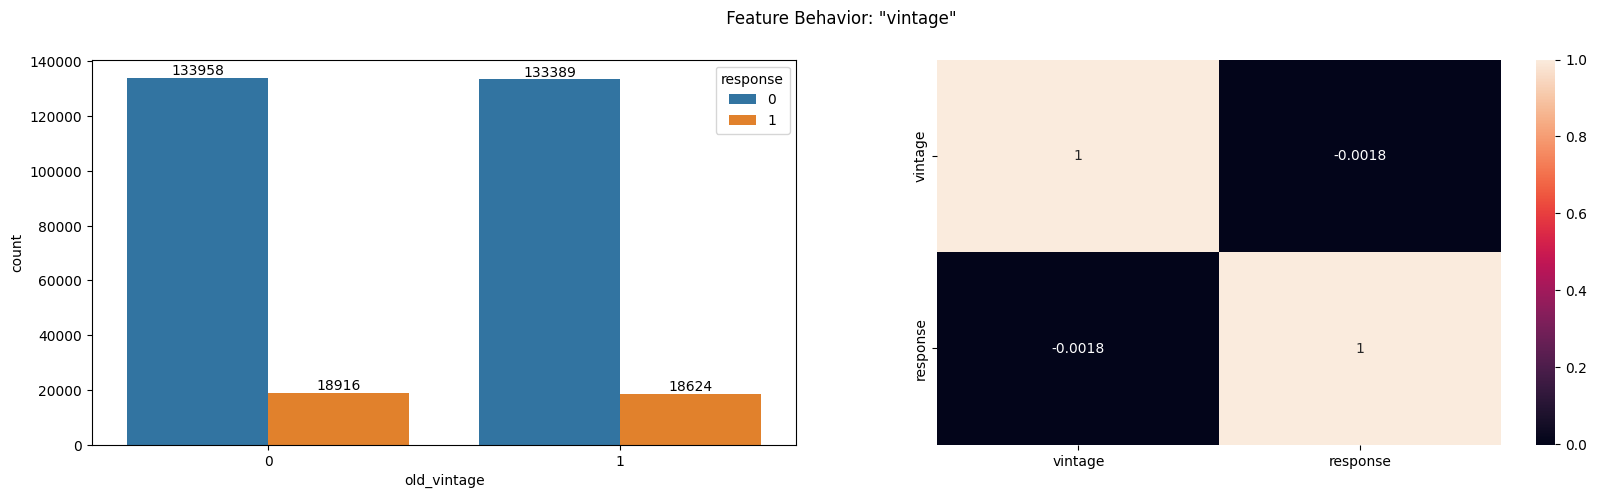

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5) )
fig.suptitle(' Feature Behavior: "vintage" ')

# sales x assortments - total
aux1 = df3[['old_vintage', 'response', 'id']].groupby( ['old_vintage', 'response'] ).count().reset_index().rename( columns= { 'id' : 'count' } )
ax=sns.barplot( x='old_vintage', y='count', hue='response', data=aux1, ax=axes[0]);
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f')

# sales x competition_distance corr method
aux3 = df3[['vintage', 'response']]
sns.heatmap( aux3.corr( method='pearson' ), annot=True, ax=axes[1] );

### 3.2.1 Resumo das Hipóteses

In [37]:
tab = [ ['Hipóteses', 'Conclusão', 'Relevância'],
        ['H1', 'Falsa', 'Baixa'],
        ['H2', 'Falsa', 'Baixa'],
        ['H3', 'Falsa', 'Baixa'],
        ['H4', 'Falsa', 'Baixa'],
        ['H5', '-', '-'],
        ['H6', 'Falsa', 'Baixa'],
        ['H7', 'Falsa', 'Alta'],
        ['H8', 'Falsa', 'Alta'],
        ['H9', 'Falsa', 'Alta'],
        ['H10', 'Verdadeira', 'Média'],
        ['H11', 'Verdadeira', 'Alta'],
        ['H12', 'Verdadeira', 'Baixa'],
]

print( tabulate( tab, headers='firstrow' ) )

Hipóteses    Conclusão    Relevância
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Baixa
H3           Falsa        Baixa
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Alta
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Média
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


## 3.3 Multivariate Analysis

### 3.3.1 Numerical Attributes

<Axes: >

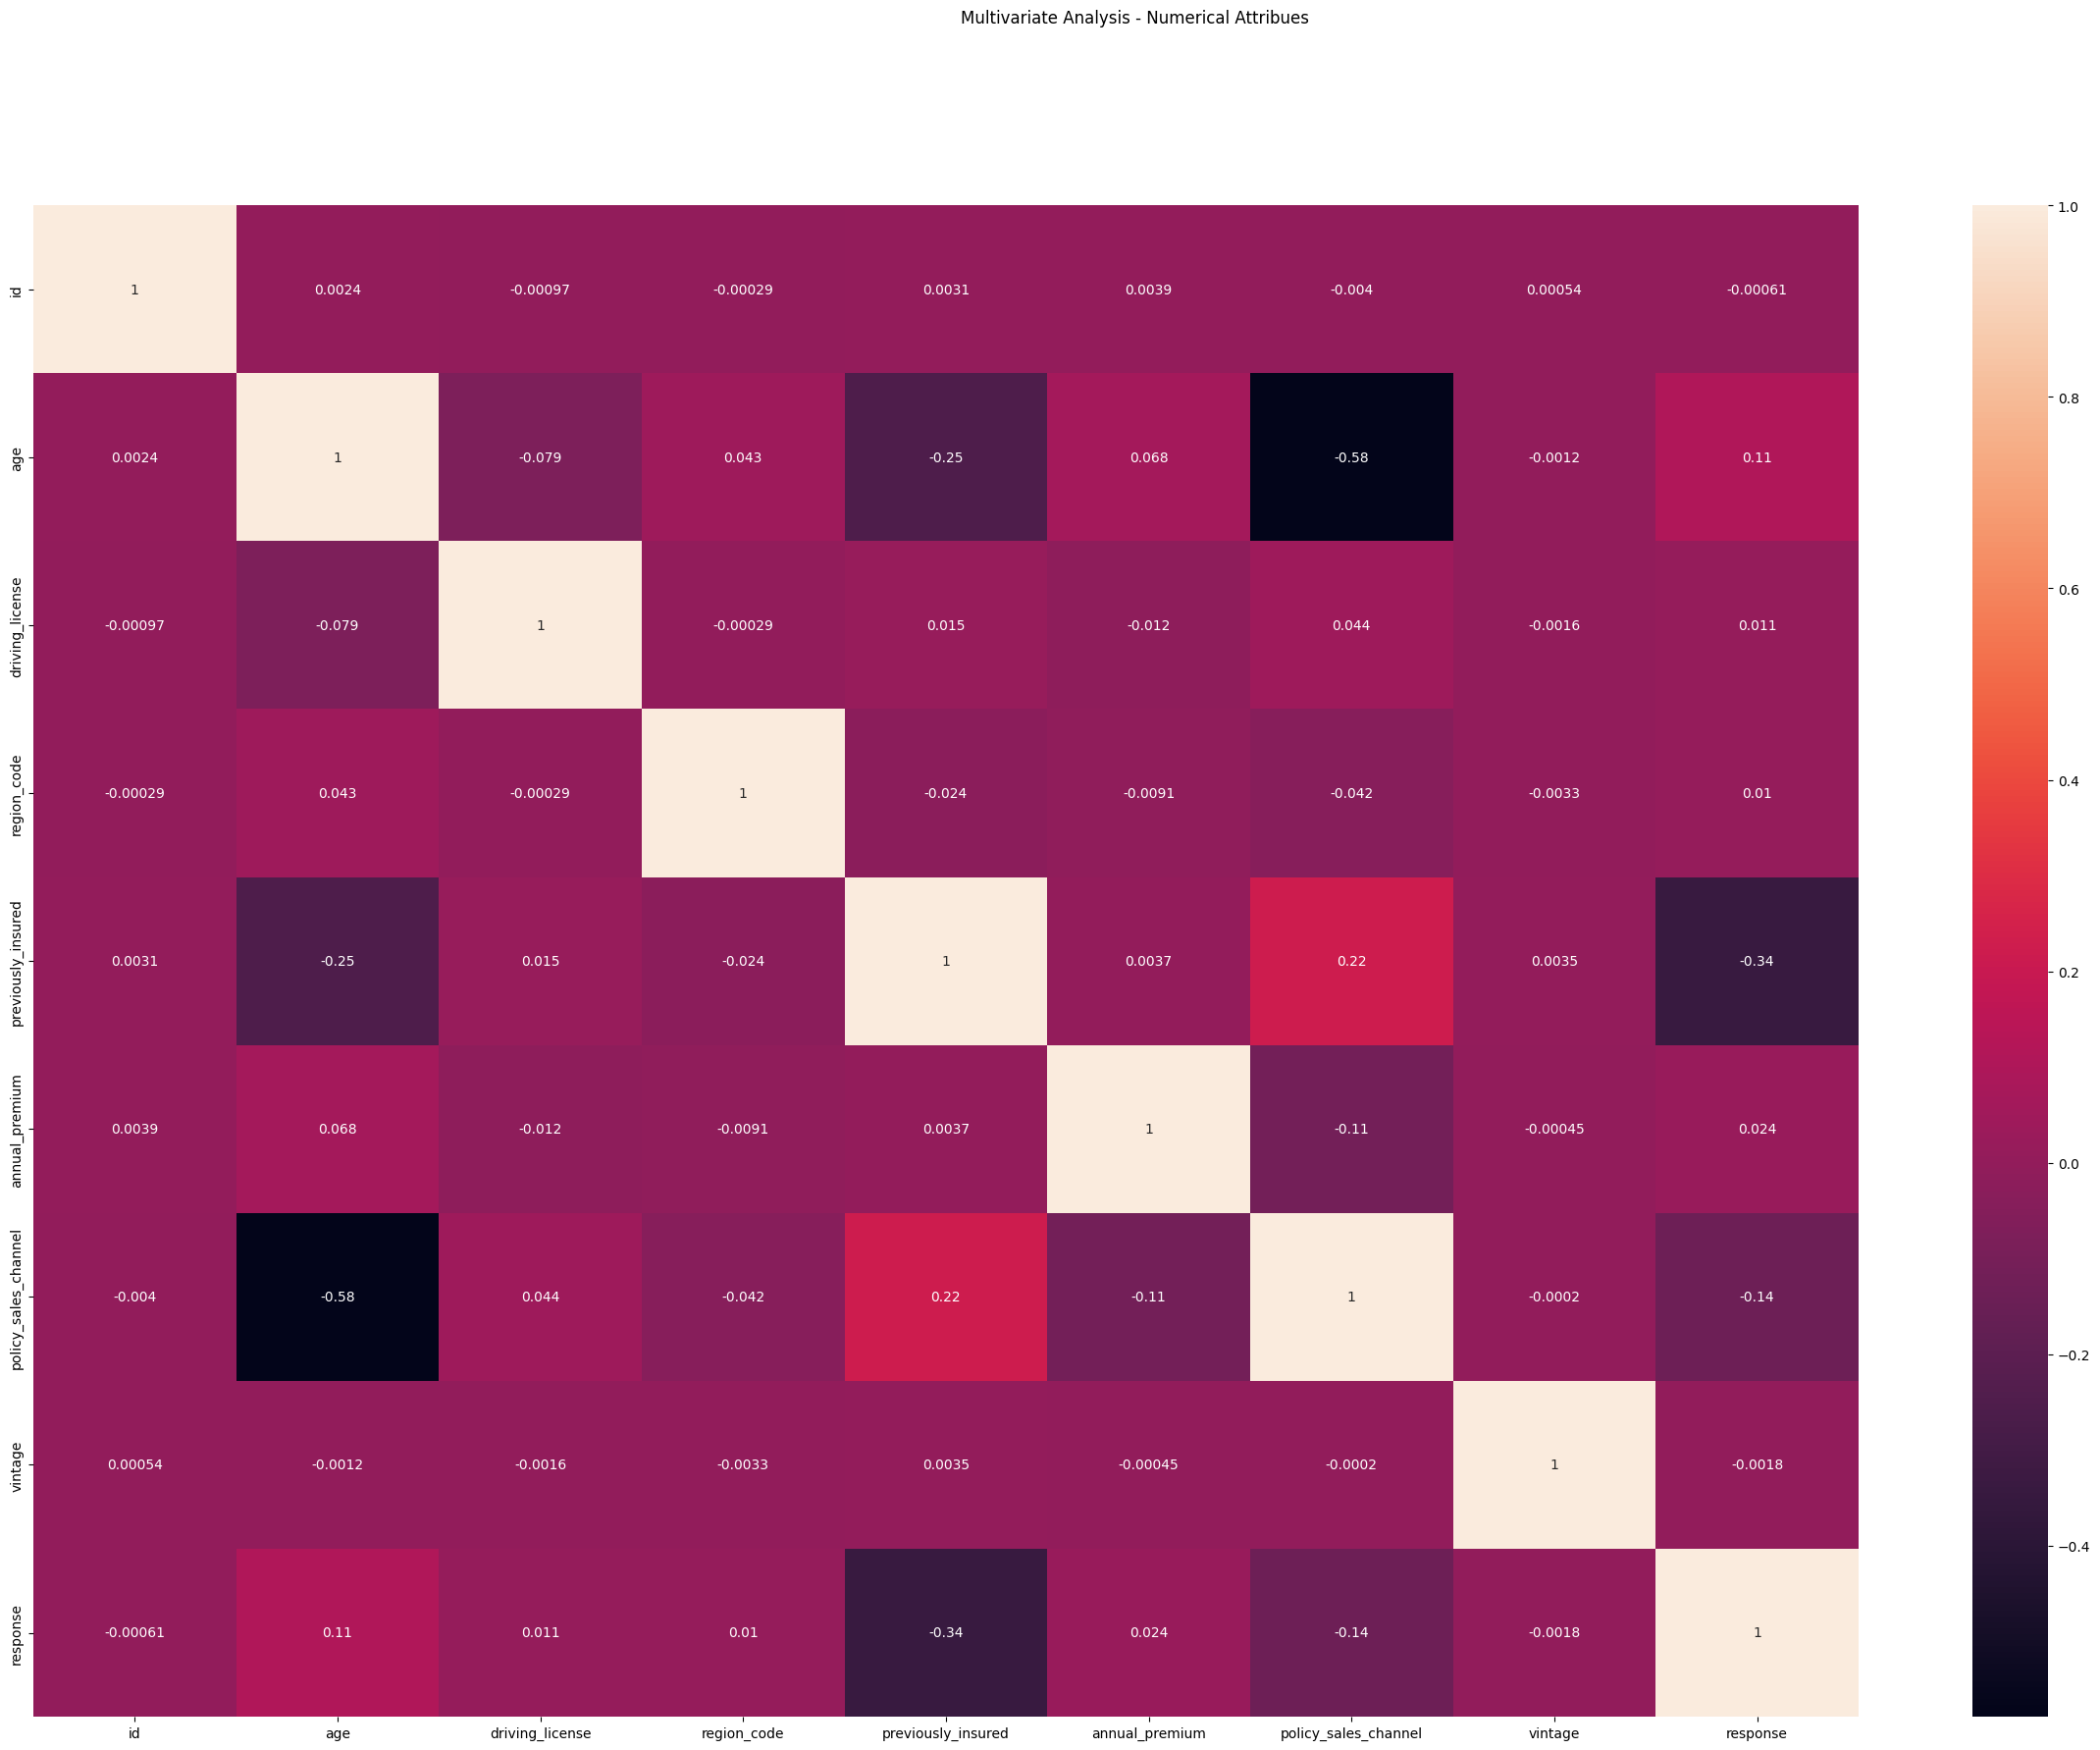

In [38]:
correlation = df_num_attributes.corr( method='pearson' )

fig, axes = plt.subplots(1, 1, figsize=(30, 20) )
fig.suptitle('Multivariate Analysis - Numerical Attribues ');

sns.heatmap( correlation, annot=True )

### 3.3.2 Categorical Attributes

In [39]:
# create a dataframe with new categorical columns
cat = df3.select_dtypes( include='object' )
cat.sample(5)


,gender,vehicle_age,vehicle_damage
107025,Male,< 1 Year,No
4175,Female,< 1 Year,No
140403,Female,< 1 Year,No
227676,Male,> 2 Years,Yes
314828,Male,1-2 Year,Yes


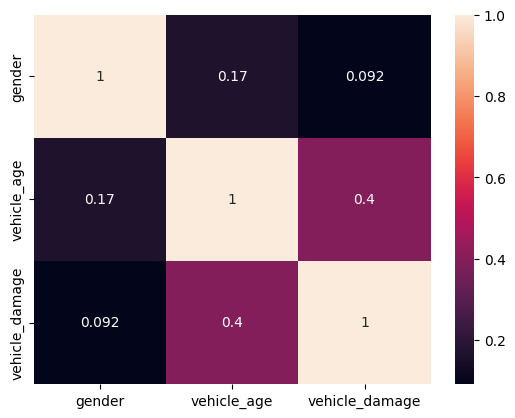

In [40]:
# calculate cramer´s v for all columns combinations 
cv1 = cramer_v( cat['gender'], cat['gender'] )
cv2 = cramer_v( cat['gender'], cat['vehicle_age'] )
cv3 = cramer_v( cat['gender'], cat['vehicle_damage'] )

cv4 = cramer_v( cat['vehicle_age'], cat['gender'] )
cv5 = cramer_v( cat['vehicle_age'], cat['vehicle_age'] )
cv6 = cramer_v( cat['vehicle_age'], cat['vehicle_damage'] )

cv7 = cramer_v( cat['vehicle_damage'], cat['gender'] )
cv8 = cramer_v( cat['vehicle_damage'], cat['vehicle_age'] )
cv9 = cramer_v( cat['vehicle_damage'], cat['vehicle_damage'] )

# create final dataframe
df = pd.DataFrame( { 'gender' : [cv1, cv2, cv3],
                     'vehicle_age'    : [cv4, cv5, cv6],
                     'vehicle_damage'    : [cv7, cv8, cv9],
                    })
df = df.set_index( df.columns )

# plot correlations between categorical attributes
sns.heatmap( df, annot=True);

# 4.0 Data Preparation

In [41]:
df4 = df3.copy()

## 4.1 Rescaling

In [42]:
df4 = rescaling_features( df4, train=True )

## 4.2 Enconding

In [43]:
df4 = encoding_features( df4 )

In [44]:
df4.dtypes

id                        int64
gender                   object
age                     float64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age               int64
vehicle_damage            int64
annual_premium          float64
policy_sales_channel    float64
vintage                 float64
response                  int64
male                      int64
old_age                   int64
old_annual_premium        int64
old_vintage               int64
dtype: object

In [45]:
df4.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response,male,old_age,old_annual_premium,old_vintage
45748,45749,Female,0.030769,1,-0.180669,1,1,0,-1.939254,0.737564,0.200692,0,0,0,0,0
150378,150379,Male,0.030769,1,1.482083,1,1,0,-0.142652,0.737564,0.664360,0,1,0,0,1
27587,27588,Female,0.630769,1,1.784402,0,2,1,0.169287,0.221183,0.387543,0,0,1,1,0
282194,282195,Female,0.138462,1,0.423968,1,1,1,0.147392,0.737564,0.418685,0,0,0,1,0
45560,45561,Male,0.046154,1,-0.105089,0,1,1,-0.662394,0.737564,0.463668,0,1,0,0,0


## 4.3 Drop Columns

In [46]:
# remove unnecessary columns
df4 = drop_cols( df4 )
df4.dtypes

id                        int64
age                     float64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age               int64
vehicle_damage            int64
annual_premium          float64
policy_sales_channel    float64
vintage                 float64
response                  int64
male                      int64
dtype: object

# 5.0 Feature Selection

In [47]:
df5 = df4.copy()
df5.dtypes

id                        int64
age                     float64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age               int64
vehicle_damage            int64
annual_premium          float64
policy_sales_channel    float64
vintage                 float64
response                  int64
male                      int64
dtype: object

## 5.1 Features Importance

In [48]:
# model definition
forest = ExtraTreesClassifier( n_estimators=250, random_state=0, n_jobs=-1 )

# data preparation
x_train_n = df5.drop( columns=['id', 'response'], axis=1 )
y_train_n = y_train.values
forest.fit( x_train_n, y_train_n )

importances = forest.feature_importances_
std = np.std( [tree.feature_importances_ for tree in forest.estimators_], axis=0 )
indices = np.argsort( importances )[::-1]

# print feature ranking
print('Feature ranking:')
df= pd.DataFrame()

for i,j in zip( x_train_n, forest.feature_importances_ ):
    aux = pd.DataFrame( {'feature' : i, 'importance' : j }, index=[0] )
    df = pd.concat( [df, aux], axis=0 )

print( df.sort_values( 'importance', ascending=False ) )

Feature ranking:
                feature  importance
0               vintage    0.273664
0        annual_premium    0.241971
0                   age    0.148797
0           region_code    0.109164
0        vehicle_damage    0.079577
0  policy_sales_channel    0.071288
0    previously_insured    0.052179
0           vehicle_age    0.017897
0                  male    0.004960
0       driving_license    0.000504


## 5.2 Final Features 

In [49]:
df5 = select_features( df5 )
df5.head()

,vintage,annual_premium,age,region_code,vehicle_damage,policy_sales_channel,previously_insured,id,response
45748,0.200692,-1.939254,0.030769,-0.180669,0,0.737564,1,45749,0
150378,0.664360,-0.142652,0.030769,1.482083,0,0.737564,1,150379,0
27587,0.387543,0.169287,0.630769,1.784402,1,0.221183,0,27588,0
282194,0.418685,0.147392,0.138462,0.423968,1,0.737564,1,282195,0
45560,0.463668,-0.662394,0.046154,-0.105089,1,0.737564,0,45561,0


# 6.0 Machine Learning Modelling

In [50]:
# create datasets
X_train, x_train, y_train                = create_dataset( X_train, train=True )
X_validation, x_validation, y_validation = create_dataset( X_validation )
X_test, x_test, y_test                   = create_dataset( X_test )

## 6.1 KNN Model

In [51]:
# model definition
knn_model = KNeighborsClassifier( n_neighbors = 9 )

# model training
knn_model.fit( x_train, y_train )

# model predictions
y_hat_knn = knn_model.predict_proba( x_validation )

# create dataframe response with propensity score (response=1)
df_score = get_propensity_score( x_validation, y_validation, y_hat_knn )

# get precision and recall metrics
df_knn_precision, df_knn_recall = get_precision_recall( df_score, 'KNN' )


## KNN - Cross validation

In [52]:
#knn_model_cv   = KNeighborsClassifier( n_neighbors = 9 )
#df_precision_knn, df_recall_knn1, knn_model_cv = cross_validation( X_train, X_validation, 5, 'KNN', knn_model_cv, verbose=True )

## 6.2 Logistic Regression Model

In [53]:
# model definition
lr_model = lm.LogisticRegression( random_state=42 )

# model training
lr_model.fit( x_train, y_train )

# model predict
y_hat_lr = lr_model.predict_proba( x_validation )

# create dataframe response with propensity score (response=1)
df_score = get_propensity_score( x_validation, y_validation, y_hat_lr )

# get precision and recall metrics
df_lr_precision, df_lr_recall = get_precision_recall( df_score, 'Logistic_Regression' )


## 6.3 Extra Trees Model

In [54]:
# model definition
et_model = ExtraTreesClassifier( n_estimators=100, random_state=42, n_jobs=-1 )

# model training
et_model.fit( x_train, y_train )

# model predict
y_hat_et = et_model.predict_proba( x_validation )

# create dataframe response with propensity score (response=1)
df_score = get_propensity_score( x_validation, y_validation, y_hat_et )

# get precision and recall metrics
df_et_precision, df_et_recall = get_precision_recall( df_score, 'Extra_Trees' )


## 6.4 Random Forest Model

In [55]:
# define model
rf_model = RandomForestClassifier( n_estimators=100, n_jobs=-1, random_state=42 )

# training model
rf_model.fit( x_train, y_train )

# model predict
y_hat_rf = rf_model.predict_proba( x_validation )

# create dataframe response with propensity score (response=1)
df_score = get_propensity_score( x_validation, y_validation, y_hat_rf )

# get precision and recall metrics
df_rf_precision, df_rf_recall = get_precision_recall( df_score, 'Random_Forest' )


## 6.5 Models Performance

### 6.5.1 Precision Table

In [56]:
df_precision = pd.concat( [df_knn_precision, df_lr_precision, df_et_precision, df_rf_precision], axis=1 )
df_precision

,KNN,Logistic_Regression,Extra_Trees,Random_Forest
0,0.3409,0.3353,0.3406,0.3490
1,0.3098,0.3006,0.3238,0.3231
2,0.2901,0.2784,0.3002,0.2984
3,0.2638,0.2533,0.2741,0.2735
4,0.2251,0.2401,0.2393,0.2390
5,0.1909,0.2029,0.2019,0.2018
6,0.1662,0.1740,0.1734,0.1732
7,0.1477,0.1523,0.1519,0.1519
8,0.1334,0.1354,0.1352,0.1353
9,0.1219,0.1219,0.1219,0.1219


### 6.5.2 Recall Table

In [57]:
df_recall = pd.concat( [df_knn_recall, df_lr_recall, df_et_recall, df_rf_recall], axis=1 )
df_recall

,KNN,Logistic_Regression,Extra_Trees,Random_Forest
0,0.2796,0.2751,0.2794,0.2863
1,0.5082,0.4931,0.5312,0.5301
2,0.7139,0.6851,0.7387,0.7344
3,0.8657,0.8313,0.8993,0.8973
4,0.9232,0.9847,0.9815,0.9802
5,0.9393,0.9987,0.9938,0.9931
6,0.9544,0.9991,0.9957,0.9946
7,0.9690,0.9996,0.9968,0.9970
8,0.9845,0.9998,0.9981,0.9985
9,1.0000,1.0000,1.0000,1.0000


### 6.5.3 Cumulative Gains Curve

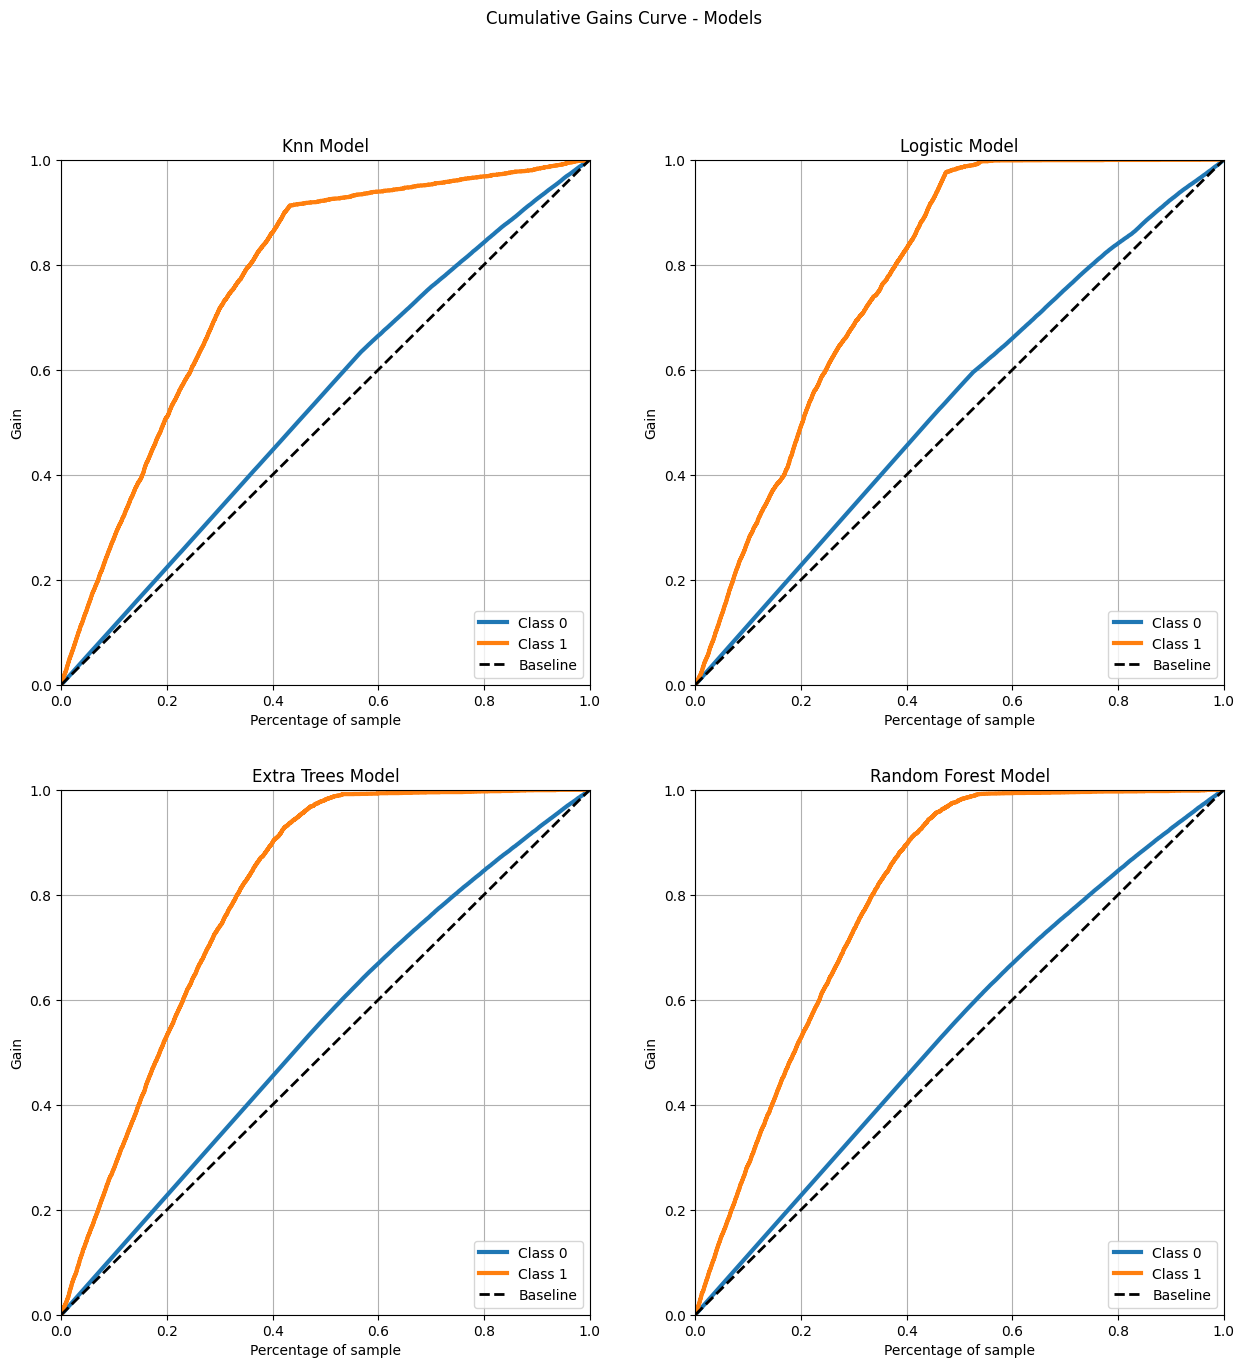

In [58]:
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
fig.suptitle('Cumulative Gains Curve - Models')

# gender
skplt.metrics.plot_cumulative_gain( y_validation, y_hat_knn, ax=axes[0,0], title='Knn Model' );
skplt.metrics.plot_cumulative_gain( y_validation, y_hat_lr,  ax=axes[0,1], title='Logistic Model' );
skplt.metrics.plot_cumulative_gain( y_validation, y_hat_et,  ax=axes[1,0], title='Extra Trees Model' );
skplt.metrics.plot_cumulative_gain( y_validation, y_hat_rf,  ax=axes[1,1], title='Random Forest Model' );

# 7.0 Hyperparameter Fine Tunning

# 8.0 Testing Final Model - Logistic Regression

## 8.1 Prepare Train and Test Datasets

In [59]:
# concat X_train and X_validation as new X_train
X_train = pd.concat( [X_train, X_validation] )
y_train = X_train['response']
x_train = X_train.drop( columns=['id', 'response'], axis=1 )

## 8.2 Training and Test Final Model

In [73]:
# model definition
model = lm.LogisticRegression( random_state=42 )

# model training
model.fit( x_train, y_train )

# model predict
y_hat = model.predict_proba( x_test )

# create dataframe response with propensity score (response=1)
df_score = get_propensity_score( x_test, y_test, y_hat )

# get precision and recall metrics
df_model_precision, df_model_recall = get_precision_recall( df_score, 'Logistic_Regression - Final Model' )

## 8.3 Final Model Performance - Report to Business

### 8.3.1 Precision Table

In [75]:
df_precision = pd.concat( [df_lr_precision, df_model_precision], axis=1 )
df_precision

,Logistic_Regression,Logistic_Regression - Final Model
0,0.3353,0.3377
1,0.3006,0.2989
2,0.2784,0.2718
3,0.2533,0.2469
4,0.2401,0.2332
5,0.2029,0.1975
6,0.1740,0.1694
7,0.1523,0.1483
8,0.1354,0.1318
9,0.1219,0.1187


### 8.3.2 Recall Table

In [74]:
df_recall = pd.concat( [df_lr_recall, df_model_recall], axis=1 )
df_recall

,Logistic_Regression,Logistic_Regression - Final Model
0,0.2751,0.2845
1,0.4931,0.5035
2,0.6851,0.6868
3,0.8313,0.8320
4,0.9847,0.9821
5,0.9987,0.9982
6,0.9991,0.9987
7,0.9996,0.9993
8,0.9998,0.9993
9,1.0000,1.0000


### 8.3.3 Cumulative Gain Curve

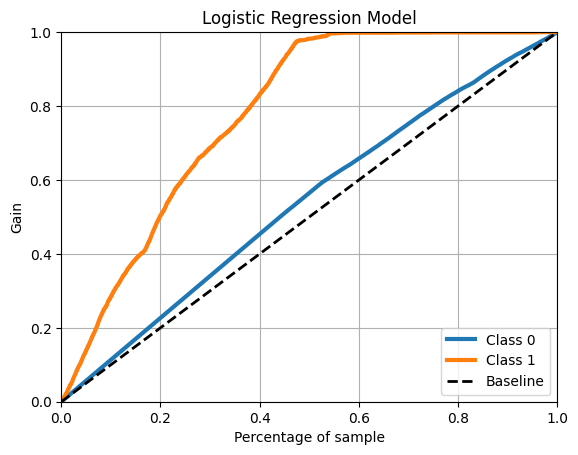

In [71]:
#fig = plt( figsize=(15, 15))
#fig.suptitle('Cumulative Gains Curve - Logistic Regression Model')
skplt.metrics.plot_cumulative_gain( y_test, y_hat, title='Logistic Regression Model' );

## 8.4 Save Final Model

In [64]:
# save Trained Model
pickle.dump( model, open( '../models/hics_model.pkl', 'wb' ) )

# 9.0 Call API Model in Production

In [109]:
df_score = get_model_prediction( '../data/test.csv', local=True )
df_score.head(10)


,id,score
0,444843,0.400545
1,407376,0.384648
2,489675,0.380566
3,438198,0.364662
4,455861,0.363189
5,457698,0.354425
6,402659,0.353263
7,433450,0.345905
8,411044,0.345259
9,427501,0.344946
